# Proyek Klasifikasi Gambar: Plant Classification
- **Nama:** Cika Rahmannia Febrianti
- **Email:** mc004d5x2144@student.devacademy.id
- **ID Dicoding:** cikarahmanniaf

## 🌿 Image Classification: 10 Types of Indonesian Plants

- Dataset ini diambil melalui kaggle (https://www.kaggle.com/datasets/marquis03/plants-classification?resource=download) berisi gambar dari 30 jenis tanaman tropis Indonesia.

- Untuk proyek ini, dipilih **10 kelas tanaman** dengan distribusi kelas seragam. Semua gambar dari folder train, val, dan test telah **digabung** agar bisa dibagi ulang secara acak.

- Tujuan dari proyek ini adalah untuk membangun sistem klasifikasi gambar berbasis **Convolutional Neural Network (CNN)** yang dapat mengenali jenis tanaman hanya dari citra visualnya.

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import warnings
from google.colab import drive
from google.colab import files

from sklearn.metrics import classification_report

# TensorFlow dan Keras
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import shutil

# Mengabaikan peringatan
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

## Data Preparation

### Data Loading

In [ ]:
# Fungsi untuk mengimpor gambar
def import_images(path):
    data = []
    target = []

    categories = os.listdir(path)
    for label in categories:
        folder = os.path.join(path, label)
        files = os.listdir(folder)

        for file in tqdm(files, desc=f"Mengambil gambar dari {label}"):
            full_path = os.path.join(folder, file)
            img = cv2.imread(full_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                data.append(img)
                target.append(label)

    return np.array(data, dtype='uint8'), target

In [ ]:
# Fungsi untuk preview gambar per label
def preview_images_by_label(images, labels, sample=1):
    labels = np.array(labels)
    for name in np.unique(labels):
        idxs = np.where(labels == name)[0][:sample]
        plt.figure(figsize=(6, 3))
        for i, idx in enumerate(idxs):
            plt.subplot(1, sample, i + 1)
            plt.imshow(images[idx].astype("uint8"))
            plt.title(name)
            plt.axis("off")
        plt.suptitle(f"Sample untuk Kategori: {name}")
        plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mengambil gambar dari banana: 100%|██████████| 1000/1000 [00:05<00:00, 167.49it/s]


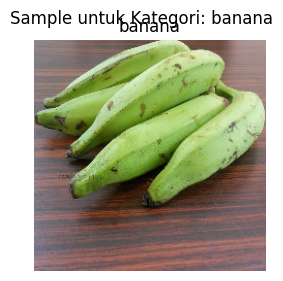

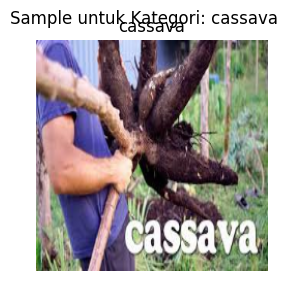

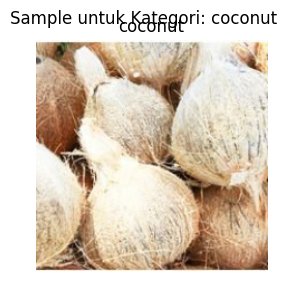

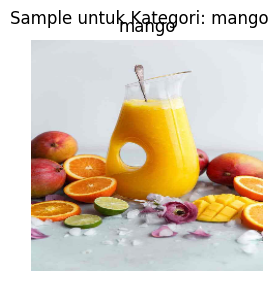

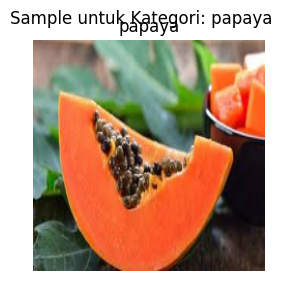

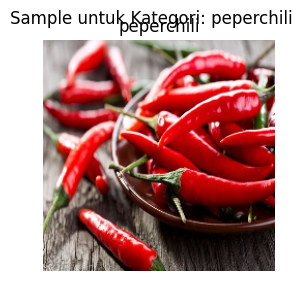

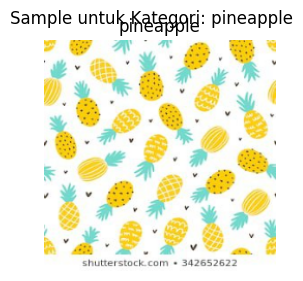

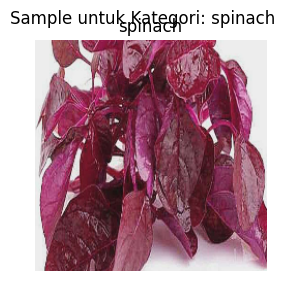

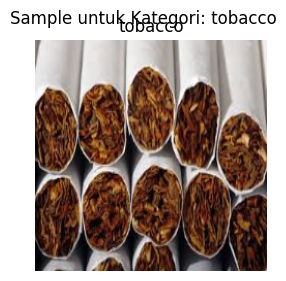

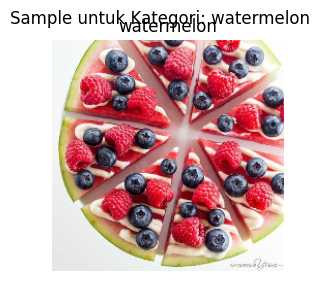

In [ ]:
# Load dan menampilkan data
drive.mount('/content/drive')

source_dir = '/content/drive/MyDrive/Coding Camp 2025 /Proyek 4 Klasifikasi Gambar_Cika Rahmannia Febrianti/plants'
images, classes = import_images(source_dir)
preview_images_by_label(images, classes)

In [ ]:
print(f"Jumlah gambar         : {len(images)}")
print(f"Label unik            : {np.unique(classes)}")

Jumlah gambar         : 10000
Label unik            : ['banana' 'cassava' 'coconut' 'mango' 'papaya' 'peperchili' 'pineapple'
 'spinach' 'tobacco' 'watermelon']


### Data Preprocessing

In [ ]:
# Ambil 70% data untuk training
train_ds_full = tf.keras.utils.image_dataset_from_directory(
    source_dir,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=(128, 128),
    batch_size=16
)

# Ambil 30% data sisanya untuk validasi + test
valtest_ds = tf.keras.utils.image_dataset_from_directory(
    source_dir,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=16
)

# Bagi valtest menjadi 10% validation (1/3 dari 30%) dan 20% testing (2/3 dari 30%)
valtest_unbatched = valtest_ds.unbatch().cache()
val_size = int((1/3) * 3000)
val_ds = valtest_unbatched.take(val_size).batch(32)
test_ds = valtest_unbatched.skip(val_size).batch(32)

# Prefetch untuk efisiensi saat training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_full.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10000 files belonging to 10 classes.
Using 7000 files for training.
Found 10000 files belonging to 10 classes.
Using 3000 files for validation.


keterangan: split data 70:10:20 dari 10000 baris data atau train (7000)-val (1000)-test (2000)

## Modelling

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

In [ ]:
# Load base model MobileNetV2
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'   # Pakai bobot pre-trained dari ImageNet
)
base_model.trainable = False  # Freeze base model

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Arsitektur model CNN
model = models.Sequential([
    layers.Input(shape=(128, 128, 3), name="input_layer"),

    layers.Rescaling(1./255, name="rescale"),

    # Base Model
    base_model,

    # Tambahan Conv2D setelah Base Model
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="custom_conv1"),
    layers.BatchNormalization(name="custom_bn1"),
    layers.MaxPooling2D((2, 2), name="custom_pool1"),

    layers.GlobalAveragePooling2D(name="global_avg_pool"),
    layers.Dense(128, activation='relu', name="dense_hidden"),
    layers.Dropout(0.5, name="dropout"),
    layers.Dense(10, activation='softmax', name="output_layer")
], name="final_sequential_model")

In [ ]:
model.summary()

Model: "final_sequential_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescale (Rescaling)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv1 (Conv2D)           │ (None, 4, 4, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_bn1 (BatchNormalization) │ (None, 4, 4, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_pool1 (MaxPooling2D)     │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,632,298 (10.04 MB)

 Trainable params: 374,250 (1.43 MB)

 Non-trainable params: 2,258,048 (8.61 MB)

In [ ]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

In [ ]:
# Train model
history = model.fit(
    train_ds.map(lambda x, y: (data_augmentation(x), y)),
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6205 - loss: 1.1922

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


438/438 ━━━━━━━━━━━━━━━━━━━━ 57s 102ms/step - accuracy: 0.6208 - loss: 1.1915 - val_accuracy: 0.8870 - val_loss: 0.3617 - learning_rate: 0.0010
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.8481 - loss: 0.4986 - val_accuracy: 0.8700 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.8815 - loss: 0.3790 - val_accuracy: 0.9000 - val_loss: 0.3200 - learning_rate: 0.0010
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.8925 - loss: 0.3375 - val_accuracy: 0.8840 - val_loss: 0.3420 - learning_rate: 0.0010
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.9102 - loss: 0.2902 - val_accuracy: 0.8980 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9203 - loss: 0.2439
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
438/438 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.9203 - loss: 0.2439 

## Evaluasi dan Visualisasi

In [ ]:
# Evaluasi akurasi
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9774
Validation Accuracy: 0.9280
Test Accuracy: 0.9215


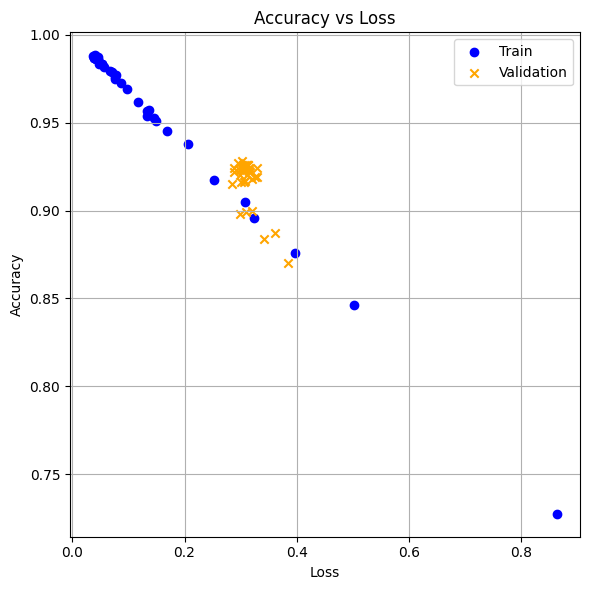

In [ ]:
# Grafik Accuracy terhadap Loss
plt.figure(figsize=(6, 6))
plt.scatter(history.history['loss'], history.history['accuracy'], label='Train', c='blue', marker='o')
plt.scatter(history.history['val_loss'], history.history['val_accuracy'], label='Validation', c='orange', marker='x')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

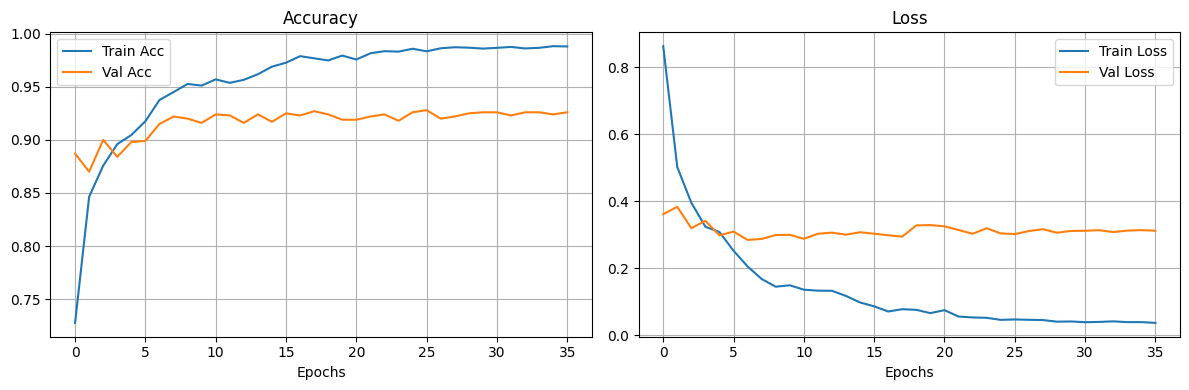

In [ ]:
# Grafik Accuracy dan Loss di setiap epochs
def plot_history(hist):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Ekstrak y_true dan X dari test_ds
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

source_dir = '/content/drive/MyDrive/Coding Camp 2025 /Proyek 4 Klasifikasi Gambar_Cika Rahmannia Febrianti/plants'
class_names = sorted(os.listdir(source_dir))
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━

In [88]:
# Simpan model ke file .h5
model.save('model_klasifikasi.h5')

In [89]:
files.download('model_klasifikasi.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Konversi Model

In [90]:
# Simpan model ke format SavedModel
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138781481194640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481193680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481193872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481190032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481204048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481189648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481190224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481191376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481191952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481193488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481194832: Te

In [91]:
# Zip folder saved_model
shutil.make_archive('saved_model', 'zip', 'saved_model')

# Download hasil zip
files.download('saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
# Konversi model Keras ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
os.makedirs('model_tflite', exist_ok=True)
with open('model_tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label class ke file JSON
class_names = ['banana', 'cassava', 'coconut', 'mango', 'papaya', 'peperchili', 'pineapple', 'spinach', 'tobacco', 'watermelon']
with open('model_tflite/class_names.json', 'w') as f:
    json.dump(class_names, f)

Saved artifact at '/tmp/tmpxy0loqg1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138781481194640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481193680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481193872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481190032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481204048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481189648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481190224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481191376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481191952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138781481193488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13878148119483

In [93]:
# Download file model
files.download('model_tflite/model.tflite')

# Download file label class
files.download('model_tflite/class_names.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
model.save('model_klasifikasi.keras')

# Konversi langsung ke folder tujuan
!tensorflowjs_converter \
    --input_format=keras \
    /content/model_klasifikasi.h5 \
    /content/model_tfjs

2025-04-29 04:46:12.597383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745901972.632562   52870 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745901972.643212   52870 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [100]:
# Zip folder model_tfjs
shutil.make_archive('model_tfjs', 'zip', 'model_tfjs')

# Download hasil zip
files.download('model_tfjs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

Saving mangga.jpg to mangga.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


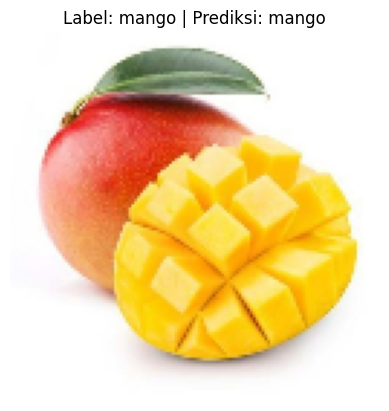

In [102]:
# Memuat model
model_test = load_model('model_klasifikasi.h5')
class_names = ['banana', 'cassava', 'coconut', 'mango', 'papaya',
               'peperchili', 'pineapple', 'spinach', 'tobacco', 'watermelon']

# Fungsi preprocessing gambar
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Gambar tidak ditemukan di path: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, (128, 128))           # Resize
    img = img.astype('float32') / 255.0          # Normalisasi
    return img

# Fungsi untuk menampilkan gambar dan hasil prediksi
def show_prediction(img, true_label, pred_label):
    plt.imshow(img)
    plt.title(f"Label: {true_label} | Prediksi: {pred_label}")
    plt.axis('off')
    plt.show()

# Upload gambar untuk diuji
from google.colab import files
uploaded = files.upload()

# Ambil nama file gambar yang diupload
test_image_path = next(iter(uploaded))

# Membuat mapping nama file ke label
file_to_label_mapping = {
    'mangga.jpg': 'mango',
}

# Proses gambar untuk inference
try:
    img = preprocess_image(test_image_path)
    input_img = np.expand_dims(img, axis=0)

    # Prediksi dengan model
    pred = model_test.predict(input_img)
    pred_class = class_names[np.argmax(pred)]

    # Ambil true label dari nama file
    true_label = file_to_label_mapping.get(test_image_path, 'Unknown')

    show_prediction(img, true_label, pred_class)
except Exception as e:
    print(f"Terjadi kesalahan: {e}")